# Intro to mcmc

We come to the Monte Carlo Markov Chain(MCMC). I have used the [guide](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) provided by Thomas Wiecki to guide the first bits of code. Let's start by giving a definition. 
*   __"A MCMC is a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps are included, the more closely the distribution of the sample matches the actual desired distribution."__ -Wikipedia

The ingredients: 
*   A desired distibution: continuous, unknown but proportional to a know function
*   A markov chain: its equilibrium distribution is proportional to the function 
*   A sampling algorithm (or sampler): iterated over large n, think of this as a bounded electron; types of samplers include gibbs, metropolis, metropolis-hastings, hamiltonian, NUTS

Let's dig into content. It basically takes a homemade sampler and considers the metropolis-hastings as well

$$ \begin{multline}
\begin{aligned}
\text{What Bayes tells us about Probability, aka the foundation of Bayesian Stats} & \\
P(\theta|x) = \frac{P(x|\theta)P(\theta)}{P(x)} \\ 
\end{aligned}
\end{multline}
$$

This formula is important because unlike what the proabability textbooks suggest, real life parameters are not fixed. Bayesian stats helps because they add a lot of flexible and powerful tools for the statistician.

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
from scipy import stats
import seaborn as sns
import pymc3 as pymc

from scipy.stats import norm
from scipy.stats import poisson

#we remove warnings on distplot deprecated
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pymc3'

In [13]:
np.random.seed(123)
data = np.random.randn(20)

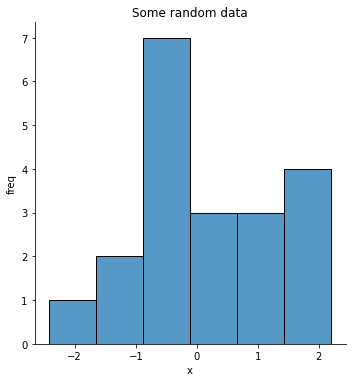

In [14]:
p = sns.displot(data, kde=False)
p.set(title='Some random data', xlabel='x', ylabel='freq')

Fix $\sigma = 1$. Thus some distribution $x|\mu \sim Normal(x; \mu, 1)$

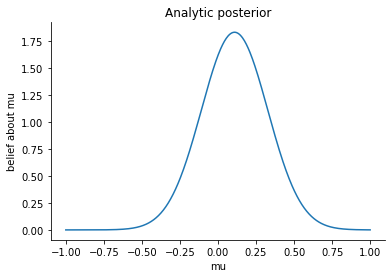

In [15]:
def calc_posterior_analytical (data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + (n / sigma**2))
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief about mu', title='Analytic posterior');
sns.despine()

In [16]:
def samplerMetropolis(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    
    #initialize mu
    mu_current = mu_init
    posterior = [mu_current]
    
    for i in range (samples):
        #suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()
        
        #compute likelihoods by multiplying probs at each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

        #Compute prior probability of current and proposed mean mu
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        #Nominator of Bayes formula
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        #accept / reject
        p_accept = p_proposal / p_current
        
        #no info about prior
        accept = np.random.rand() <= p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            #Update the position of mu
            mu_current = mu_proposal
            
        posterior.append(mu_current)
        
    return np.array(posterior)

In [17]:
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16,4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
    
    #Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color ='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', 
            title='current: prior(mu=%.2f) = %.2f\nproposal:prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    #Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(mu_proposal, 1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot()
    ax2.axvline()
    ax2.axvline()
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(ylabel='belief', 
            title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    #posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color ='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                arrowprops=dict(arrowstyle="->", lw=2.))
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)    
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

array([-1.        , -0.63131571,  0.1140503 ,  0.1140503 ,  0.1140503 ,
        0.04401594,  0.04401594,  0.04401594,  0.04401594])

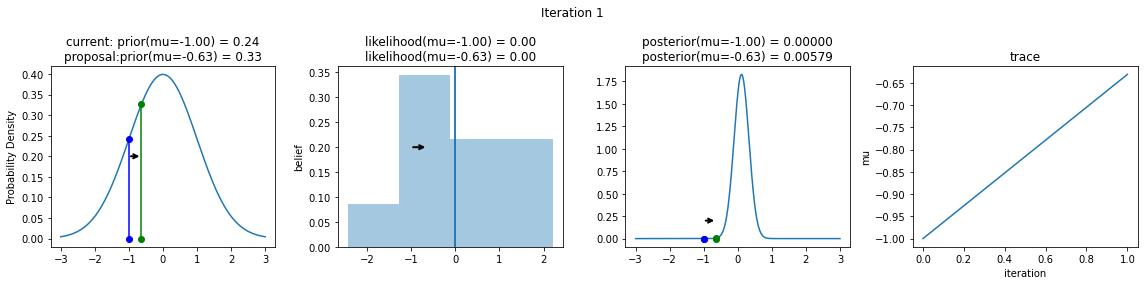

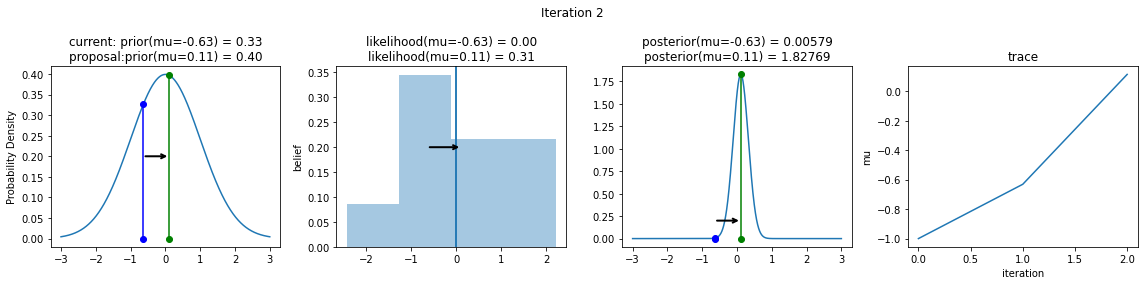

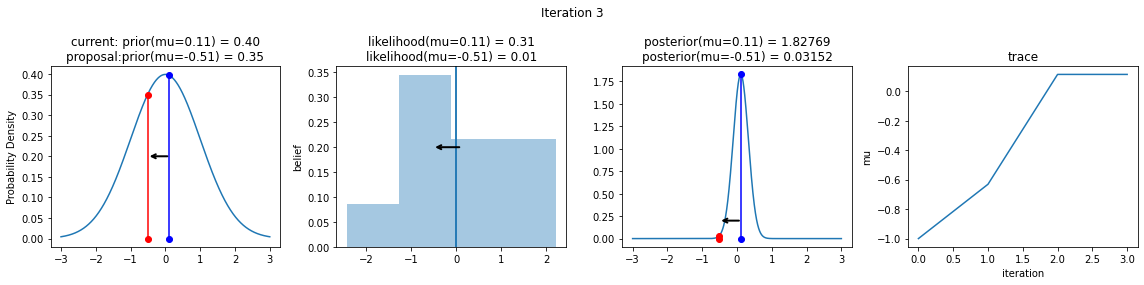

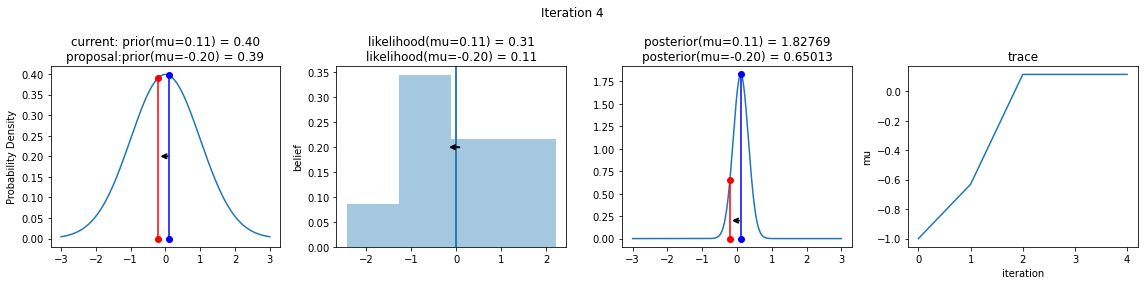

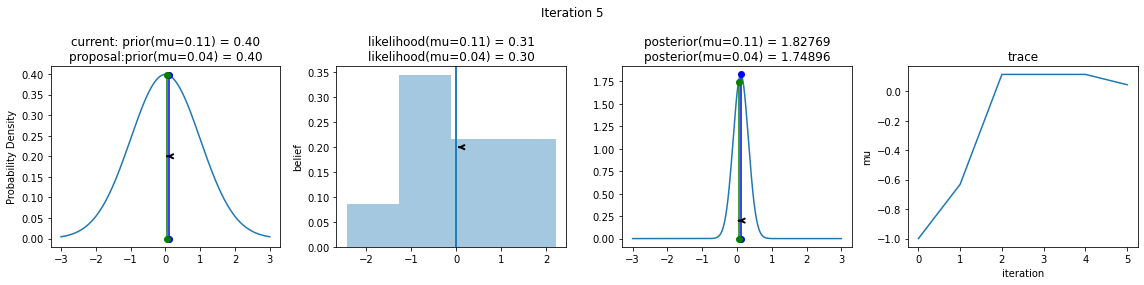

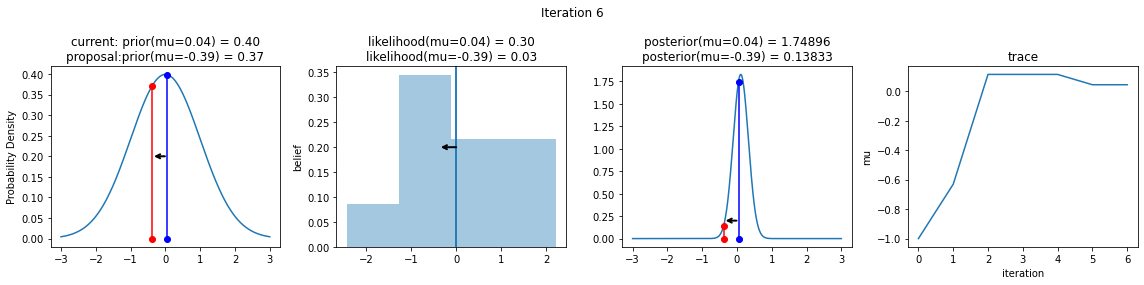

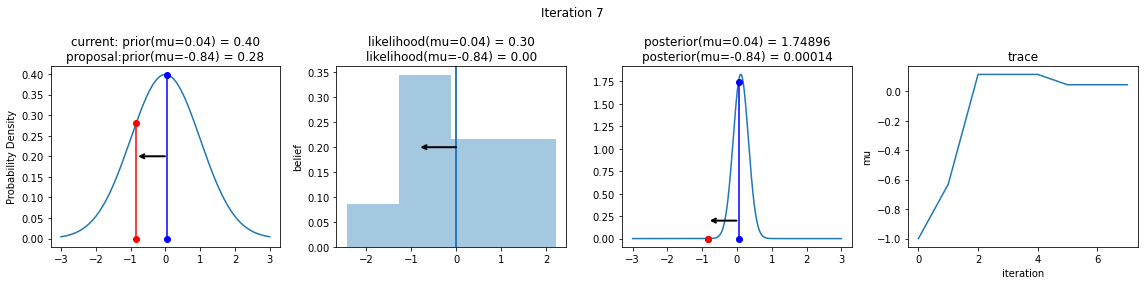

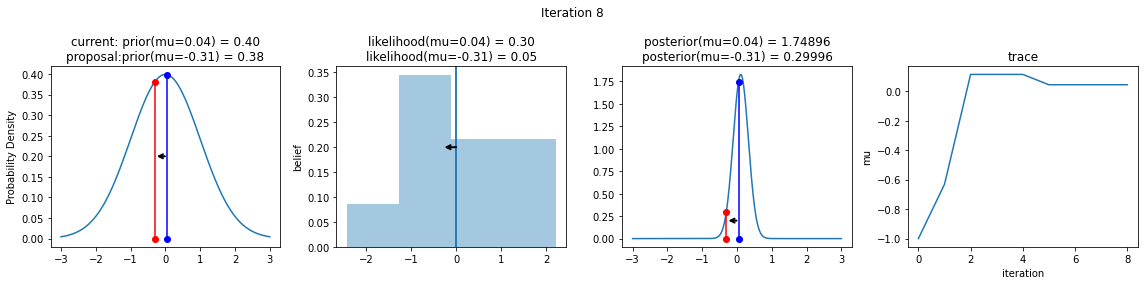

In [18]:
samplerMetropolis(data, samples = 8, mu_init=-1., plot=True)

[Text(0.5, 1.0, 'Normal density with mean parameter drawn from a Metropolis sampler'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'frequency')]

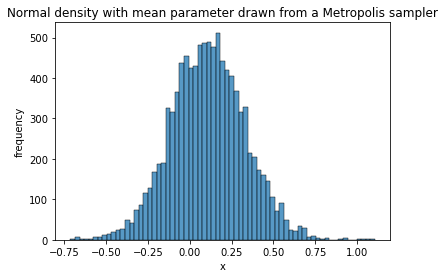

In [21]:
n = 10000
mu_0 = samplerMetropolis(data, samples = n, mu_init=1., proposal_width=.2)
p = sns.histplot(pd.Series(mu_0))
p.set(title='Normal density with mean parameter drawn from a Metropolis sampler', xlabel='x', ylabel='frequency')

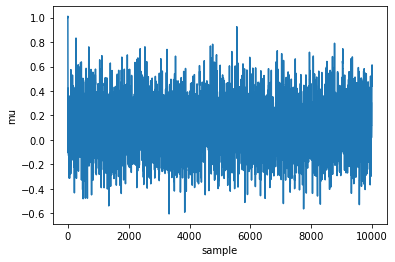

In [22]:
#this is called a trace plot because it shows the Mkv chain's progression from intitial state to top state
posterior = samplerMetropolis(data, samples=10000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='samples', ylabel='mu')

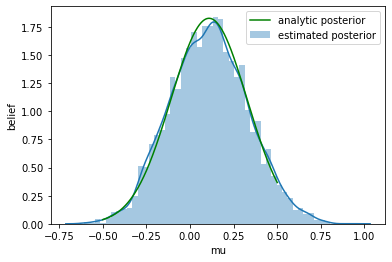

In [23]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5,.5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

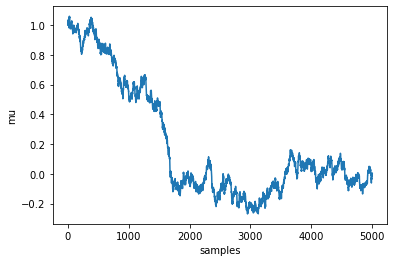

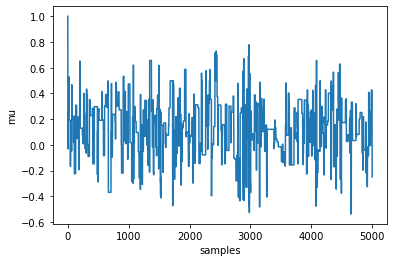

In [29]:
#try small proposal width
posterior_small = samplerMetropolis(data, 5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small)
_ = ax.set(xlabel='samples', ylabel='mu')

#try large proposal width
posterior_large = samplerMetropolis(data, 5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large)
_ = ax.set(xlabel='samples', ylabel='mu')

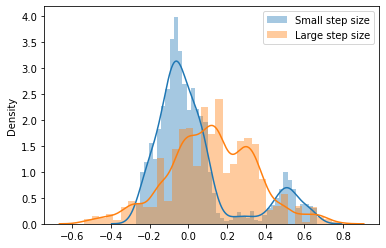

In [30]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

# Intro to Copula

A copula is 
*   __"a multivariate cumulative distribution function for which the marginal probability distribution of each variable is uniform on the interval [0, 1]. Copulas are used to describe the dependence between random variables."__ -Wikipedia

We emphasize that this does not give indication of the distribution of the multivariate CDF. This is one of the features that make them flexible. In jargon, what the definition means is:


$$ \begin{multline}
\begin{aligned}
C(u_1, u_2, ..., u_n) = Pr[U_1 \leq u_1, U_2 \leq u_2,..., U_n \leq u_n] \\ 
\text{We can sample from the copula function} \\
(X_1, X_2,.., X_n) = (F_{1}^{-1}(U_1), F_{2}^{-1}(U_2), ..., F_{n}^{-1}(U_n)) \\ 
\end{aligned}
\end{multline}
$$

Visiting the following [wikipedia page](https://en.wikipedia.org/wiki/Copula_(probability_theory)), we can see that the definitions quickly become verbose. I have found the following [blog article by Thomas Wiecki (2018)](https://twiecki.io/blog/2018/05/03/copulas/) to be an intuitive guide to copulas and how they work 

Here is the jyst: 
*   We can transform from any continuous distribution to the $U$niform(0,1) and back. No problem. This is the __probability integral transform__
*   Since this is possible, we can put correlations on a bivariate $N$ormal, marginalize to $U$niform and then transform again to the any old continuous distribution 

In [ ]:
#Let's see this in action using python
import matplotlib as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

In [ ]:
#sample from X~U(0,1)

X = stats.uniform(0,1).rvs(5000)
sns.distplot(X, kde=False, norm_hist=True)

$U$niform to $N$ormal

In [ ]:
norm = stats.distributions.norm()
X_trans = norm.ppf(X)
sns.distplot(X_trans)

In [ ]:
p = sns.jointplot(x=X, y=X_trans)
p.set_axis_labels('original uniform','transformed normal', fontsize=16)

In [ ]:
beta_10_3 = stats.distributions.beta(a=10, b=3)
beta_5_3 = stats.distributions.beta(a=5, b=3)
beta_1_3 = stats.distributions.beta(a=1, b=3)

p1 = sns.jointplot(X, beta_10_3.ppf(X))
p2 = sns.jointplot(X, beta_5_3.ppf(X))
p3 = sns.jointplot(X, beta_1_3.ppf(X))

p1.set_axis_labels('original uniform','transformed beta(10,3)', fontsize=16)
p2.set_axis_labels('original uniform','transformed beta(5,3)', fontsize=16)
p3.set_axis_labels('original uniform','transformed beta(1,3)', fontsize=16)

In [ ]:
#what is the gumbel_l distribution ?
gumbel = stats.distributions.gumbel_l()
X_trans = gumbel.ppf(X)
p = sns.jointplot(X, X_trans)
p.set_axis_labels('original uniform','transformed gumbel l', fontsize=16)

In [ ]:
#transpose transpose - the magic happens
X_trans_trans = gumbel.cdf(X_trans)
p = sns.jointplot(X_trans, X_trans_trans)
p.set_axis_labels('uniform -> gumbel','uniform -> gumbel -> uniform', fontsize=16)

In [ ]:
bivnorm = stats.multivariate_normal(
    mean=[0, 0],
    cov =[[1., 0.5],
         [0.5, 1.]])
#draw from bivariate normal
#cor = 0.5, n = 5000
XY = bivnorm.rvs(5000)

In [ ]:
p = sns.kdeplot(XY[:, 0], XY[:, 1], fill=True,
               thresh=0, levels=20, cmap="mako")

In [ ]:
norm = stats.norm()
X_unif = norm.cdf(XY)
#plot1 does not show
p1 = sns.kdeplot(X_unif[:, 0], X_unif[:, 1], fill=True,
               thresh=0, levels=5, cmap="mako");
p2 = sns.kdeplot(X_unif[:, 0], X_unif[:, 1], fill=True,
               thresh=0, levels=20, cmap="mako");
p3 = sns.jointplot(X_unif[:, 0], X_unif[:, 1],
                  kind='hex', cmap="mako");

In [ ]:
gumbel = stats.gumbel_l()
beta = stats.beta(a=10, b=2)

gumbel_trans = gumbel.ppf(X_unif[:, 0])
beta_trans = beta.ppf(X_unif[:, 1])

#plot the jointplot on top of sns.kdeplot
p = sns.jointplot(gumbel_trans, beta_trans, 
                  marker = ".", s=20, height=10, ratio=10, color="b", xlim=(-6, 4), ylim=(0.5, 1.1))
p.plot_joint(sns.kdeplot, fill=True,
               thresh=0, levels=20, cmap="crest")
p.plot_marginals(sns.rugplot, color="m", height=-.05, clip_on=False)

In [ ]:
#kdeplot is very messy...
#need to be able to label, and add layers to it in the same flexible way as in joinplot()
p = sns.kdeplot(gumbel_trans, beta_trans, fill=True,
                thresh=0, levels=20, cmap="crest",
                xlim=(-6, 4), ylim=(0.5, 1.1))
p.plot_joint(sns.jointplot, fill=True,
             marker = ".", s=20, height=10, ratio=10, color="b")
p.plot_marginals(sns.rugplot, color="m", height=-.05, clip_on=False)

In [ ]:
x1 = gumbel.rvs(5000)
x2 = beta.rvs(5000)

p = sns.jointplot(x1, x2, 
                  marker = ".", s=20, height=10, ratio=10, color="b", xlim=(-6, 4), ylim=(0.5, 1.1))
p.plot_joint(sns.kdeplot, fill=True,
               thresh=0, levels=20, cmap="crest")
p.plot_marginals(sns.rugplot, color="m", height=-.05, clip_on=False)